# Advanced linear model for the January TPS with customer confidence index

This notebook contains some major changes compared to my earlier [linear model](https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model):
- Feature engineering
  - more external data: monthly consumer confidence index
  - different selection of Fourier series; no Fourier series for stickers
  - Small changes in length of holidays
  - Different Easter effect for Norway than for other countries
- Cross-validation shows results for Q1 and the other three quarters separately.
- Regularization has been tuned with three MinMaxScalers
- KaggleRama factor has been taken out of the regression (direct computation is more accurate)


In [1]:
import pandas as pd
import numpy as np
import pickle
import itertools
import gc
import math
import matplotlib.pyplot as plt
import dateutil.easter as easter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from datetime import datetime, date, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
import scipy.stats

In [2]:
NO_STORE = True

original_train_df = pd.read_csv('../input/tabular-playground-series-jan-2022/train.csv')
original_test_df = pd.read_csv('../input/tabular-playground-series-jan-2022/test.csv')

gdp_df = pd.read_csv('../input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')
gdp_df.set_index('year', inplace=True)

cci_df = pd.read_csv('../input/oecd-consumer-confidence-index/DP_LIVE_21012022073653464.csv')
cci_df.set_index(['LOCATION', 'TIME'], inplace=True)

# The dates are read as strings and must be converted
for df in [original_train_df, original_test_df]:
    df['date'] = pd.to_datetime(df.date)
original_train_df.head(6)

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911
5,5,2015-01-01,Finland,KaggleRama,Kaggle Sticker,283


Before starting, we calculate the ratio between KaggleRama and KaggleMart sales. This ratio is always the same and does not depend on any other features. A direct calculation is more accurate than linear regression:

In [3]:
kaggle_rama_log_diff = \
    np.log(original_train_df[original_train_df.store == "KaggleRama"].num_sold.values).mean() - \
    np.log(original_train_df[original_train_df.store == "KaggleMart"].num_sold.values).mean()
print(f"KaggleRama always sells {np.exp(kaggle_rama_log_diff):.5f} more than KaggleMart.")

KaggleRama always sells 1.74377 more than KaggleMart.


In [4]:
def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200


# Feature engineering


In [5]:
# Feature engineering
def engineer(df):
    """Return a new dataframe with the engineered features"""
    
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]
        
    def get_cci(row):
        country = row.country
        time = f"{row.date.year}-{row.date.month:02d}"
        # There is no monthly CCI data for Norway.
        # We use the Finland data instead.
        if country == 'Norway': country = 'Finland'
        return cci_df.loc[country[:3].upper(), time].Value
        
    new_df = pd.DataFrame({'gdp': np.log(df.apply(get_gdp, axis=1)),
                           'cci': df.apply(get_cci, axis=1),
                           'wd4': df.date.dt.weekday == 4, # Friday
                           'wd56': df.date.dt.weekday >= 5, # Saturday and Sunday
                          })

    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        new_df[product] = df['product'] == product
        
    # Seasonal variations (Fourier series)
    # The three products have different seasonal patterns
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        sink = np.sin(dayofyear / 365 * 2 * math.pi * k)
        cosk = np.cos(dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = sink * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = cosk * new_df['Kaggle Mug']
        new_df[f'hat_sin{k}'] = sink * new_df['Kaggle Hat']
        new_df[f'hat_cos{k}'] = cosk * new_df['Kaggle Hat']

    new_df.drop(columns=['mug_sin1'], inplace=True)
    new_df.drop(columns=['mug_sin2'], inplace=True)

    # Special days
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d)
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(25, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(1, 15)}),
                        pd.DataFrame({f"n-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(1, 15)})
                       ],
                       axis=1)
    
    # May and June
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}),
#                         pd.DataFrame({f"f-may{d}":
#                                       (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Finland') # end of the war
#                                       for d in [9]}),
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
                                     for d in list(range(18, 26)) + [27]}),
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in list(range(8, 15))}),
                       ],
                       axis=1)
    
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(-4, 5))})],
                       axis=1)
    
    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"sun_nov{d}": 
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
                                      for d in list(range(0, 9))})],
                       axis=1)
    
    # First half of December (Independence Day of Finland, 6th of December)
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 15))})],
                       axis=1)

    # Easter
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    new_df = pd.concat([new_df,
                        pd.DataFrame({f"easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(51, 58))}),
                        pd.DataFrame({f"n_easter{d}": 
                                      (df.date - easter_date == np.timedelta64(d, "D")) & (df.country == 'Norway')
                                      for d in list(range(-3, 8)) + list(range(50, 61))})],
                       axis=1)
    
    return new_df.astype(np.float32)

train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer(original_test_df)

features = list(test_df.columns)
if NO_STORE: features.remove('KaggleRama')
print(list(features))


['gdp', 'cci', 'wd4', 'wd56', 'Finland', 'Norway', 'Kaggle Mug', 'Kaggle Hat', 'mug_cos1', 'hat_sin1', 'hat_cos1', 'mug_cos2', 'hat_sin2', 'hat_cos2', 'dec24', 'dec25', 'dec26', 'dec27', 'dec28', 'dec29', 'dec30', 'dec31', 'n-dec25', 'n-dec26', 'n-dec27', 'n-dec28', 'n-dec29', 'n-dec30', 'n-dec31', 'f-jan1', 'f-jan2', 'f-jan3', 'f-jan4', 'f-jan5', 'f-jan6', 'f-jan7', 'f-jan8', 'f-jan9', 'f-jan10', 'f-jan11', 'f-jan12', 'f-jan13', 'f-jan14', 'n-jan1', 'n-jan2', 'n-jan3', 'n-jan4', 'n-jan5', 'n-jan6', 'n-jan7', 'n-jan8', 'n-jan9', 's-jan1', 's-jan2', 's-jan3', 's-jan4', 's-jan5', 's-jan6', 's-jan7', 's-jan8', 's-jan9', 's-jan10', 's-jan11', 's-jan12', 's-jan13', 's-jan14', 'may1', 'may2', 'may3', 'may4', 'may5', 'may6', 'may7', 'may8', 'may9', 'may18', 'may19', 'may20', 'may21', 'may22', 'may23', 'may24', 'may25', 'may27', 'june8', 'june9', 'june10', 'june11', 'june12', 'june13', 'june14', 'wed_june-4', 'wed_june-3', 'wed_june-2', 'wed_june-1', 'wed_june0', 'wed_june1', 'wed_june2', 'wed

# Validation

We train on a GroupKFold with the years as groups. For the validation, we separate the SMAPE for the first quarter from the rest of the year. As the private leaderboard is computed on the predictions for April through December, SMAPE for these nine months is more important than SMAPE for the first quarter.

The data is scaled using three separate MinMaxScalers. Ridge regression will penalize high weights on the customer confidence index more than on other features.

In [6]:
def predict(features, preproc, model, X):
    y = (np.exp(model.predict(preproc.transform(X[features])))).reshape(-1, 1)
    if NO_STORE: y[X.KaggleRama.values > 0] = y[X.KaggleRama.values > 0] * np.exp(kaggle_rama_log_diff)
    return y


def fit_model(X_tr, X_va=None, score_list=[], mse_list=[], run=0, fold=0, oof=None, outliers=False, correction=1.0):
    """Scale the data, fit a model, plot the training history and validate the model"""
    start_time = datetime.now()

    # Preprocess the data
    X_tr_f = X_tr[features]
    preproc = make_pipeline(ColumnTransformer([('general', MinMaxScaler(), ['gdp', 'wd4', 'wd56', 'Finland', 'Norway',
                                                                            'Kaggle Mug', 'Kaggle Hat',
                                                                            'mug_cos1', 'hat_sin1', 'hat_cos1', 'mug_cos2',
                                                                            'hat_sin2', 'hat_cos2']),
                                               ('cci', MinMaxScaler((0, 0.06)), ['cci']),
                                              ],
                                              remainder=MinMaxScaler((0, 2.8))),
                            StandardScaler(with_std=False))
    #preproc = make_pipeline(MinMaxScaler(), StandardScaler(with_std=False))
    #preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1).copy()
    if NO_STORE: y_tr[X_tr.KaggleRama != 0] = y_tr[X_tr.KaggleRama != 0] / np.exp(kaggle_rama_log_diff)

    # Train the model
    model = Ridge(alpha=0.2, tol=0.00001, max_iter=10000)
    model.fit(X_tr_f, np.log(y_tr).ravel())

    if X_va is not None:
        # Preprocess the validation data
        y_va = X_va.num_sold.values.reshape(-1, 1)

        # Inference for validation
        y_va_pred = predict(features, preproc, model, X_va)
        oof.update(pd.Series(y_va_pred.ravel(), index=X_va.index))
        
        # Evaluation: Execution time and SMAPE
        smape_before_correction = np.mean(smape_loss(y_va, y_va_pred))
        y_va_pred *= correction
        smape = np.mean(smape_loss(y_va, y_va_pred))
        mse = mean_squared_error(np.log(y_va), np.log(y_va_pred))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f}   (before correction: {smape_before_correction:.5f})"
              f" | MSE: {mse:.5f}")
        score_list.append(smape)
        mse_list.append(mse)
        
    return preproc, model


In [7]:
RUNS = 1 # should be 1

def validate(train_df, correction_factor=1.0):
    # Make the results reproducible
    np.random.seed(202100)

    total_start_time = datetime.now()
    oof = pd.Series(0.0, index=train_df.index)
    score_list, mse_list = [], []
    for run in range(RUNS):
        kf = GroupKFold(n_splits=4)
        for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, groups=train_df.date.dt.year)):
            X_tr = train_df.iloc[train_idx]
            X_va = train_df.iloc[val_idx]
            print(f"Fold {run}.{fold} validating on {train_df.iloc[val_idx].iloc[0].date.year}")
            preproc, model = fit_model(X_tr, X_va, score_list, mse_list, run=run, fold=fold, oof=oof, correction=correction_factor)

    print(f"Average SMAPE: {sum(score_list) / len(score_list):.5f} | MSE: {sum(mse_list) / len(mse_list):.7f}   "
          f"| Y: {smape_loss(train_df.num_sold, oof).mean():.5f}   "
          f"| Q1: {smape_loss(train_df.num_sold, oof)[train_df.date.dt.month <= 3].mean():.5f}   "
          f"| Q234: {smape_loss(train_df.num_sold, oof)[train_df.date.dt.month > 3].mean():.5f}")
    with open('oof.pickle', 'wb') as handle: pickle.dump(oof, handle)
        
validate(train_df)


Fold 0.0 validating on 2016
Fold 0.0 | 00:00 | SMAPE: 4.15478   (before correction: 4.15478) | MSE: 0.00270
Fold 0.1 validating on 2018
Fold 0.1 | 00:00 | SMAPE: 4.08928   (before correction: 4.08928) | MSE: 0.00266
Fold 0.2 validating on 2017
Fold 0.2 | 00:00 | SMAPE: 4.24774   (before correction: 4.24774) | MSE: 0.00282
Fold 0.3 validating on 2015
Fold 0.3 | 00:00 | SMAPE: 4.19356   (before correction: 4.19356) | MSE: 0.00286
Average SMAPE: 4.17134 | MSE: 0.0027603   | Y: 4.17133   | Q1: 4.39466   | Q234: 4.09804


# Inference and submission


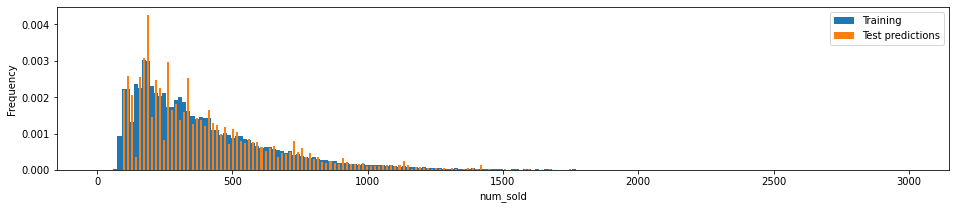

,row_id,num_sold
0,26298,383.0
1,26299,593.0
2,26300,169.0
3,26301,668.0
4,26302,1035.0
...,...,...
6565,32863,797.0
6566,32864,228.0
6567,32865,901.0
6568,32866,1391.0


In [8]:
# Fit the model on the complete training data
preproc, model = fit_model(train_df, None)

# Inference for test
test_pred_list = []
test_pred_list.append(predict(features, preproc, model, test_df) * 1.003) # magic scaling factor

# Prepare the submission file
sub = original_test_df[['row_id']].copy()
sub['num_sold'] = sum(test_pred_list) / len(test_pred_list)

# Plot the distribution of the test predictions
plt.figure(figsize=(16,3))
plt.hist(train_df['num_sold'], bins=np.linspace(0, 3000, 201),
         density=True, label='Training')
plt.hist(sub['num_sold'], bins=np.linspace(0, 3000, 201),
         density=True, rwidth=0.5, label='Test predictions')
plt.xlabel('num_sold')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Create a rounded submission file
sub_rounded = sub.copy()
sub_rounded['num_sold'] = sub_rounded['num_sold'].round()
sub_rounded.to_csv('submission_linear_model_rounded.csv', index=False)
sub_rounded